In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, LSTM, Dense, Reshape

# Parámetros (puedes cambiar height y width a valores más altos)
image_folder = '../data/Img_test/'
future_steps = 6
height, width, channels = 450, 450, 3  # Ajusta height y width aquí

# Obtener el número total de imágenes
image_files = sorted([f for f in os.listdir(image_folder) if f.startswith('OR_ABI-L2')])
sequence_length = 138

# Verifica que haya suficientes imágenes para formar secuencias
if sequence_length <= 0:
    raise ValueError("No hay suficientes imágenes para formar secuencias con los parámetros dados.")

print(f"Número total de archivos de imagen: {len(image_files)}")
print(f"sequence_length: {sequence_length}, future_steps: {future_steps}")

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalizar
    return image

# Función para cargar secuencias de imágenes
def load_image_sequences(folder, sequence_length, future_steps):
    X = []
    y = []
    image_files = sorted([f for f in os.listdir(folder) if f.startswith('OR_ABI-L2')])
    
    for i in range(0, len(image_files) - sequence_length - future_steps + 1):
        sequence_images = []
        future_images = []

        for j in range(sequence_length):
            image_path = os.path.join(folder, image_files[i + j])
            image = load_and_preprocess_image(image_path, target_size=(height, width))
            sequence_images.append(image)

        for k in range(sequence_length, sequence_length + future_steps):
            image_path = os.path.join(folder, image_files[i + k])
            image = load_and_preprocess_image(image_path, target_size=(height, width))
            future_images.append(image)

        X.append(sequence_images)
        y.append(future_images)

    return np.array(X), np.array(y)

# Cargar secuencias de imágenes
X, y = load_image_sequences(image_folder, sequence_length, future_steps)

if X.size == 0 or y.size == 0:
    print("No se encontraron secuencias de imágenes válidas.")
else:
    # Extraer características usando VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
    flatten_layer = Flatten()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=flatten_layer)

    def extract_features(image_sequences):
        num_sequences = image_sequences.shape[0]
        features = np.zeros((num_sequences, sequence_length, feature_extractor.output_shape[1]))

        for i in range(num_sequences):
            for j in range(sequence_length):
                image = image_sequences[i, j]
                image = np.expand_dims(image, axis=0)  # Añadir dimensión del lote
                feature = feature_extractor.predict(image)
                features[i, j] = feature.squeeze()
        return features
    
    X_features = extract_features(X)


Número total de archivos de imagen: 144
sequence_length: 138, future_steps: 6
1/1 [==============================] - 0s 237ms/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 138, 256)          103023616 
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3645000)           936765000 
                                                                 
 reshape (Reshape)           (None, 6, 450, 450, 3)    0         
                                                                 
Total params: 1040313928 (3.88 GB)
Trainable params: 1040313928 (3.88 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 69s 69s/step - loss: 0.6084
Epoch 2/10
1/1 [==============================] - 108s 108s/step -

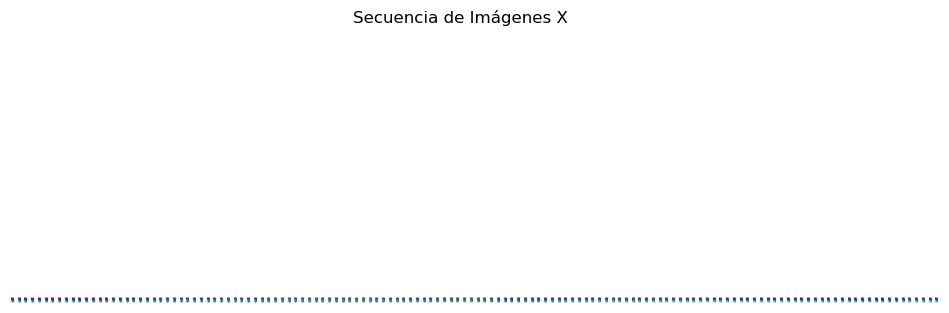

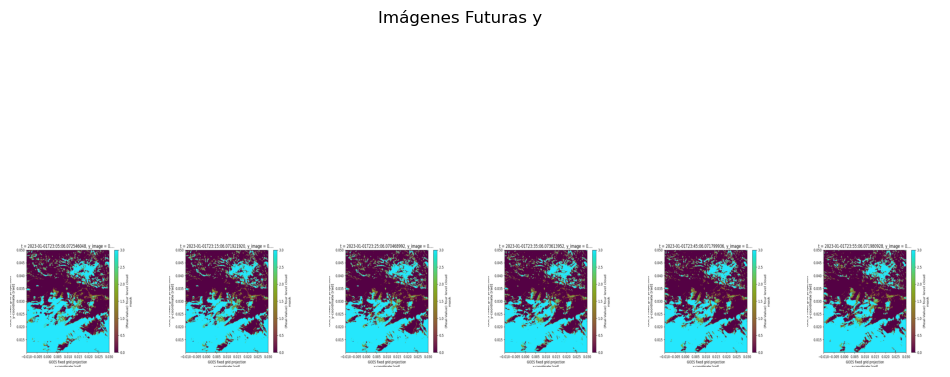

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


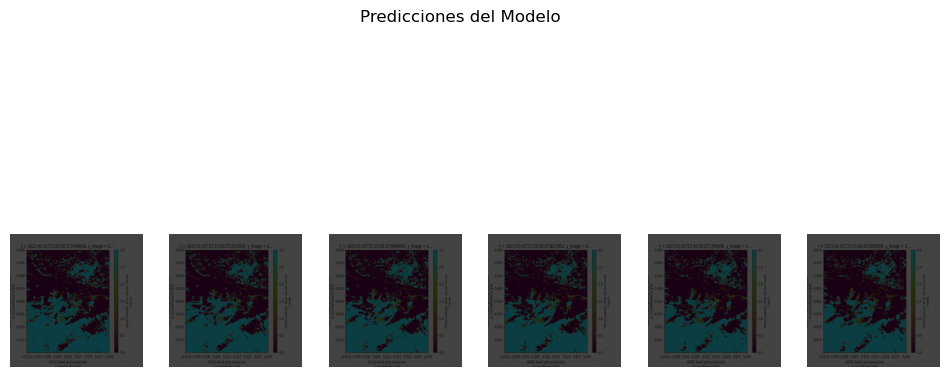

In [5]:
 # Definir el modelo LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(sequence_length, feature_extractor.output_shape[1]), return_sequences=True))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(future_steps * height * width * channels, activation='linear'))
model.add(Reshape((future_steps, height, width, channels)))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Entrenar el modelo (ajustar validation_split si hay pocas muestras)
validation_split = 0.2 if X_features.shape[0] > 1 else 0.0
if validation_split > 0:
    history = model.fit(X_features, y, epochs=10, batch_size=32, validation_split=validation_split)
else:
    history = model.fit(X_features, y, epochs=10, batch_size=32)

# Realizar predicciones
def make_predictions(model, X_features):
    y_pred = model.predict(X_features)
    return y_pred

# Guardar imágenes futuras
def save_images(images, folder, original_filenames, suffix='_pred'):
    num_sequences, future_steps, height, width, channels = images.shape
    for i in range(num_sequences):
        for j in range(future_steps):
            image = images[i, j]
            original_filename = original_filenames[i + sequence_length + j]
            base, ext = os.path.splitext(original_filename)
            new_filename = f"{base}{suffix}{ext}"
            new_filepath = os.path.join(folder, new_filename)
            image = (image * 255).astype('uint8')  # Desnormalizar
            cv2.imwrite(new_filepath, image)
            print(f"Guardada imagen: {new_filepath}")

# Obtener predicciones
y_pred = make_predictions(model, X_features)

# Guardar las imágenes futuras predichas
save_images(y_pred, image_folder, image_files)

# Función para visualizar imágenes
def mostrar_imagenes(imagenes, titulo):
    plt.figure(figsize=(12, 6))
    for i in range(imagenes.shape[0]):
        plt.subplot(1, imagenes.shape[0], i + 1)
        plt.imshow(imagenes[i])
        plt.axis('off')
    plt.suptitle(titulo)
    plt.show()

# Visualizar algunas imágenes de entrada y predicciones
indice_secuencia = 0  # Cambia este índice para visualizar diferentes secuencias
mostrar_imagenes(X[indice_secuencia], titulo='Secuencia de Imágenes X')
mostrar_imagenes(y[indice_secuencia], titulo='Imágenes Futuras y')
mostrar_imagenes(y_pred[indice_secuencia], titulo='Predicciones del Modelo')

# Función para graficar la pérdida de entrenamiento y validación
def plot_loss(history):
    loss = np.array(history.history['loss'])
    if 'val_loss' in history.history:
        val_loss = np.array(history.history['val_loss'])
        differences = np.abs(loss - val_loss)
        epoch_80 = 89  # Asumiendo que la época 90 es la 89 en el índice 0-based
        diff_epoch_80 = differences[epoch_80]

        plt.figure(figsize=(10, 6))
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.fill_between(range(len(loss)), loss, val_loss, color='green', alpha=0.2, label='Difference')

        plt.scatter(epoch_80, loss[epoch_80], color='red', zorder=5)
        plt.text(epoch_80, loss[epoch_80],
                    f'Epoch 90\nError Difference: {diff_epoch_80:.4f}',
                    horizontalalignment='left', verticalalignment='bottom', fontsize=10, color='red')

        plt.title('Loss and Validation Loss Over Epochs')
    else:
        plt.figure(figsize=(10, 6))
        plt.plot(loss, label='Training Loss')
        plt.title('Training Loss Over Epochs')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

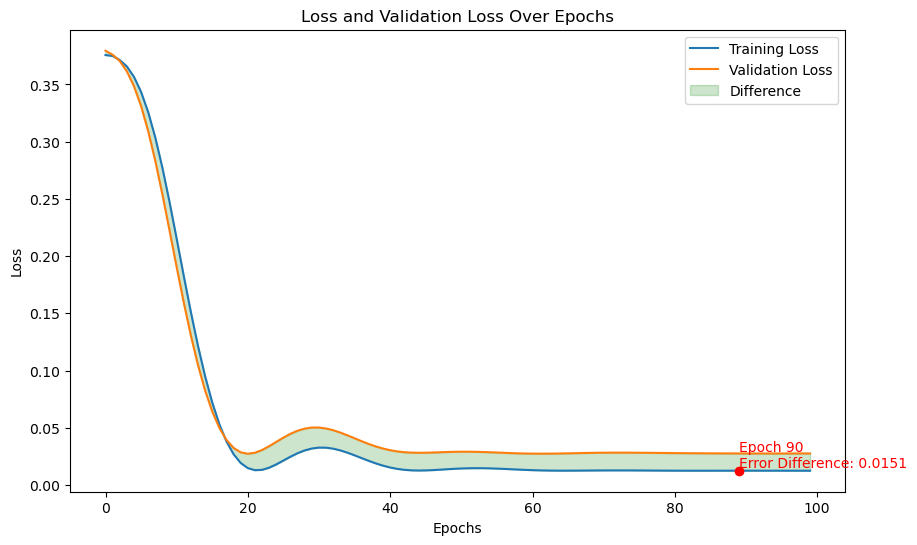

In [3]:
plot_loss(history)